In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import sys
from numba import njit
from glob import glob
from natsort import natsorted
from joblib import Parallel, delayed
sys.path.insert(0, "../../") 
import tifffile
from helpers import *
import nd2
from PIL import Image
import global_params
from tqdm.auto import tqdm
from skimage.segmentation import clear_border
sys.path.insert(0, "/home/gh464/Documents/GitHub/SyMBac/") 
from SyMBac.drawing import  get_crop_bounds_2D
from skimage.measure import label
import zarr
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.morphology import flood_fill

In [2]:
def load_img_mask_pair(img_dir, mask_dir, normalise = False):
    suffix = img_dir.split(".")[-1]
    if "png" in suffix:
        img = np.array(Image.open(img_dir))
    elif "tif" in suffix:
        img = tifffile.imread(img_dir).sum(axis=0)
    if normalise:
        img = rescale_intensity(img, out_range=(0,1))
    mask = np.array(Image.open(mask_dir)) #Masks are always PNG
    return img, mask

@njit
def get_intensities(img, mask, mask_labels, img_2 = None):
    """
    Returns intensities of objects in the order provided by mask_labels
    """
    total_intensities = np.zeros(len(mask_labels))
    for l, mask_label in enumerate(mask_labels):
        idxs = np.where(mask == mask_label)
        if len(idxs[0]) > 100:
            pixel_intensities = np.zeros(len(idxs[0]))
            for k, (i, j) in enumerate(zip(idxs[0], idxs[1])):
                pixel_intensities[k] = img[i,j]
            total_intensity = np.sum(pixel_intensities)
            total_intensities[l] = total_intensity
    total_intensities_2 = np.zeros(len(mask_labels))

    if img_2 is not None:
        total_intensities_2 = np.zeros(len(mask_labels))
        for l, mask_label in enumerate(mask_labels):
            idxs = np.where(mask == mask_label)
            if len(idxs[0]) > 100:
                pixel_intensities = np.zeros(len(idxs[0]))
                for k, (i, j) in enumerate(zip(idxs[0], idxs[1])):
                    pixel_intensities[k] = img_2[i,j]
                total_intensity = np.sum(pixel_intensities)
                total_intensities_2[l] = total_intensity
    return total_intensities, total_intensities_2

def get_colony_diameter(mask):
    colony_regionprop = regionprops((mask > 0)*1)[0]
    return colony_regionprop.feret_diameter_max


def get_colony_centroid(mask):
    colony_regionprop = regionprops((mask > 0)*1)[0]
    #colony_centroid = colony_regionprop.centroid
    return colony_regionprop.centroid

def get_cell_pos(mask, mask_labels):
    cell_ys = np.zeros(len(mask_labels))
    cell_xs = np.zeros(len(mask_labels))
    for i, mask_label in enumerate(mask_labels):
        single_cell = (mask == mask_label) * 1
        cell_ys[i], cell_xs[i] = regionprops(single_cell)[0].centroid
    return cell_ys, cell_xs
#get_colony_size(mask)

def get_cell_n_neighbours(mask,mask_labels):
    radius = 5
    dilated = dilation(mask, skimage.morphology.disk(radius))
    rag = graph.RAG(dilated)
    rag.remove_node(0)

    n_neighbours = []
    for mask_label in mask_labels:
        n_neighbours.append(len(list(rag.neighbors(mask_label))))
    return n_neighbours

def get_cell_areas(mask, mask_labels):
    areas = np.zeros(len(mask_labels))
    for i, mask_label in enumerate(mask_labels):
        areas[i] = np.sum(mask == mask_label)
    return areas

In [3]:
## Analyse only SB5, other images are poor quality
file_names = [
    "100x_SB5_dilute002"
]

seg_dirs = [glob(f"../real_data/{file_name}*") for file_name in file_names]
print(seg_dirs)

nd2_imgs = [glob(f"../real_data/agar_pads/{file_name}*.nd2") for file_name in file_names]
print(nd2_imgs)

curation_data = [glob(f"../real_data/agar_pads/{file_name}_curation*") for file_name in file_names]
curation_data

[['../real_data/100x_SB5_dilute002_segmented']]
[['../real_data/agar_pads/100x_SB5_dilute002.nd2']]


[['../real_data/agar_pads/100x_SB5_dilute002_curation.zarr']]

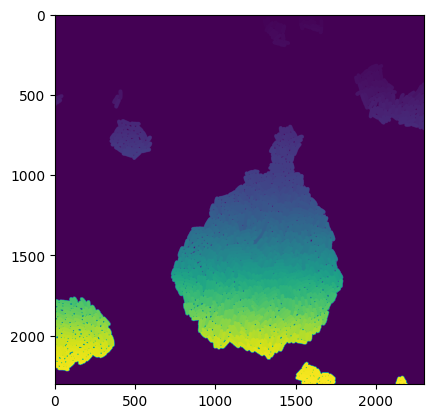

In [11]:
plt.imshow(np.array(Image.open("../real_data/100x_SB5_dilute002_segmented/002.png")))

In [4]:
def get_curation_masks(i):
    centroids = [x.centroid for x in regionprops(label(curation_position[i]))]
    curation = np.zeros_like(curation_position[i])
    for x, y in centroids:
        x = int(x)
        y = int(y)
        curation += flood_fill(curation_position[i], (x,y), 1)
    return curation > 0

In [5]:
from sdeconv.data import celegans
from sdeconv.psfs import SPSFGaussian
from sdeconv.deconv import SWiener
import torch

real_PSF = tifffile.imread("single_100x_PSF_postmag.tif").astype(np.float64)
real_PSF_slice = 44
height = 5
real_PSF -= np.round(np.sort(real_PSF[real_PSF_slice-height:real_PSF_slice+height,2].flatten())[0:int(len(real_PSF[real_PSF_slice-height:real_PSF_slice+height,2].flatten())*.05)].mean()).astype(np.uint)
real_PSF = real_PSF[real_PSF_slice-height:real_PSF_slice+height,2,:,:].sum(axis=0)
real_PSF /= real_PSF.sum()
x_offset = 4
y_offset = -6
crop = 90
psf = torch.tensor(real_PSF[crop:-crop + y_offset,crop:-crop - x_offset])


#Synthetic PSF gave better results than real
my_kernel = PSF_generator(
    radius = 350, 
    wavelength = 0.45, 
    NA=1.49, 
    n = 1.518, 
    resize_amount=1, 
    pix_mic_conv=0.0655/1.5, 
    apo_sigma = 10, 
    mode="3d fluo", 
    condenser="Ph3", 
    z_height = int(np.round(1/(0.0655/1.5))), # assume cell depth of 1 micron
    pz = 0.5, 
    working_distance=170

)
my_kernel.calculate_PSF()
synth_psf = my_kernel.kernel.sum(axis=0)
synth_psf /= synth_psf.sum()
synth_psf += 0.00000
synth_psf = torch.tensor(synth_psf)
#wiener = SWiener(psf, beta=1, pad=40)


In [6]:
plt.figure(figsize=(15,15))
raw_img_bg_subtracted_crop = raw_img_bg_subtracted#[1000:1760,700:1500]
plt.imshow(raw_img_bg_subtracted_crop,cmap="jet",vmin=0, vmax=8000)


wiener = SWiener(psf, beta=0.01, pad=10)
deconv_image = wiener(torch.tensor(raw_img_bg_subtracted)).cpu().detach().numpy() 

plt.figure(figsize=(15,15))
deconv_crop = deconv_image#[1000:1760,700:1500]
plt.imshow(deconv_crop,cmap="jet", vmin=0, vmax = 8000)

full_mask = clear_border(
    label(
        np.array(Image.open(f"{seg_dir[0]}/{str(i).zfill(3)}.png"))
    )
) * get_curation_masks(i)
plt.figure(figsize=(10,10))
plt.imshow(full_mask)

seg_dir[0]

NameError: name 'raw_img_bg_subtracted' is not defined

<Figure size 1500x1500 with 0 Axes>

In [7]:
all_data = []
for nd2_img, seg_dir in tqdm(zip(nd2_imgs, seg_dirs), total=len(nd2_imgs)):

    nd2_img = nd2.imread(nd2_img[0])
    n_imgs = nd2_img.shape[0]
    curation_position = zarr.open(curation_data[0][0])
    for i in tqdm(range(n_imgs)):
        full_mask = clear_border(
            label(
                np.array(Image.open(f"{seg_dir[0]}/{str(i).zfill(3)}.png"))
            )
        ) * get_curation_masks(i)
        raw_img = synth_img = nd2_img[i][1]

        min_5pc_intensity = np.sort(raw_img.flatten())[:int(len(raw_img.flatten())*0.05)].mean()
        raw_img_bg_subtracted = raw_img.astype(np.float64) - min_5pc_intensity
        raw_img = synth_img = np.round(raw_img_bg_subtracted * (raw_img_bg_subtracted > 0)).astype(np.uint16)
        
        colonies = label(full_mask > 0)
        colony_labels = np.unique(colonies)[1:]
        
        ## deconv
        wiener = SWiener(psf, beta=0.01, pad=10)
        deconv_image = wiener(torch.tensor(raw_img_bg_subtracted)).cpu().detach().numpy() 

        
        
        def process_colony(ID):
        #for ID in tqdm(colony_labels):
            mask = (full_mask*(colonies == ID))
            colony_circularity = get_circularity(colonies == ID)

            mask_labels = np.unique(mask)[1:]

            data = pd.DataFrame()

            data["Label"] = mask_labels
            data["True intensity"], data["Observed intensity"] = get_intensities(raw_img, mask, mask_labels, synth_img)
            data["Deconvolved intensity"], _ = get_intensities(deconv_image, mask, mask_labels, deconv_image)
            data["Colony circularity"] = colony_circularity
            data["Cell y"], data["Cell x"] = get_cell_pos(mask, mask_labels)
            data["Colony diameter"] = get_colony_diameter(mask)
            data["Colony centroid y"], data["Colony centroid x"] = get_colony_centroid(mask)
            data["N neighbours"] = get_cell_n_neighbours(mask, mask_labels)

            data["Colony N cells"] = len(mask_labels)
            #data["Colony ID"] = i
            data["Area"] = get_cell_areas(mask, mask_labels)
            return data
        datas.append( Parallel(n_jobs=-1)(delayed(process_colony)(ID) for ID in colony_labels)
    datas = Parallel(n_jobs=10)(delayed(process_image)(i) for i in tqdm(range(n_imgs)))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor.

In [21]:
data = []
for _ in datas:
    try:
        data.append(pd.concat(_))
    except:
        pass

,Label,True intensity,Observed intensity,Deconvolved intensity,Colony circularity,Cell y,Cell x,Colony diameter,Colony centroid y,Colony centroid x,N neighbours,Colony N cells,Area
0,31,2326602.0,2326602.0,2.600379e+06,1.466081,78.141431,838.917637,125.801431,100.666731,818.377565,2,4,1202.0
1,33,3029899.0,3029899.0,3.324644e+06,1.466081,100.546070,847.968157,125.801431,100.666731,818.377565,3,4,1476.0
2,34,2322460.0,2322460.0,2.615749e+06,1.466081,97.972270,791.395147,125.801431,100.666731,818.377565,3,4,1154.0
3,36,2862660.0,2862660.0,3.189782e+06,1.466081,122.621114,791.459870,125.801431,100.666731,818.377565,2,4,1383.0
0,37,4291237.0,4291237.0,4.743246e+06,1.268023,348.116413,248.039853,268.078347,435.804677,206.343626,4,25,1907.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,125,1823073.0,1823073.0,2.066156e+06,1.794684,2045.198817,90.092387,164.915130,2021.828631,138.080135,2,4,1353.0
0,121,2237948.0,2237948.0,2.598328e+06,1.481906,2008.804242,1357.450303,108.046286,2016.638712,1375.223533,1,2,1650.0
1,124,1976389.0,1976389.0,2.265917e+06,1.481906,2025.337820,1394.958277,108.046286,2016.638712,1375.223533,1,2,1486.0
0,126,1867096.0,1867096.0,2.167798e+06,1.615190,2210.194672,1227.920765,110.113578,2222.468695,1208.242306,1,2,1464.0


In [23]:
pd.concat(data).to_pickle("agar_pad_with_deconv.pickle")

In [ ]:
all_data_df = pd.concat(datas).reset_index(drop=True)

In [ ]:
all_data_df

In [ ]:
all_data_df.to_pickle("agar_pad.pickle")



In [26]:
pd.read_pickle("agar_pad_deconv.pickle").drop_duplicates()

,Label,True intensity,Observed intensity,Deconvolved intensity,Colony circularity,Cell y,Cell x,Colony diameter,Colony centroid y,Colony centroid x,N neighbours,Colony N cells,Area
0,31,2326602.0,2326602.0,2.600379e+06,1.466081,78.141431,838.917637,125.801431,100.666731,818.377565,2,4,1202.0
1,33,3029899.0,3029899.0,3.324644e+06,1.466081,100.546070,847.968157,125.801431,100.666731,818.377565,3,4,1476.0
2,34,2322460.0,2322460.0,2.615749e+06,1.466081,97.972270,791.395147,125.801431,100.666731,818.377565,3,4,1154.0
3,36,2862660.0,2862660.0,3.189782e+06,1.466081,122.621114,791.459870,125.801431,100.666731,818.377565,2,4,1383.0
0,37,4291237.0,4291237.0,4.743246e+06,1.268023,348.116413,248.039853,268.078347,435.804677,206.343626,4,25,1907.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,125,1823073.0,1823073.0,2.066156e+06,1.794684,2045.198817,90.092387,164.915130,2021.828631,138.080135,2,4,1353.0
0,121,2237948.0,2237948.0,2.598328e+06,1.481906,2008.804242,1357.450303,108.046286,2016.638712,1375.223533,1,2,1650.0
1,124,1976389.0,1976389.0,2.265917e+06,1.481906,2025.337820,1394.958277,108.046286,2016.638712,1375.223533,1,2,1486.0
0,126,1867096.0,1867096.0,2.167798e+06,1.615190,2210.194672,1227.920765,110.113578,2222.468695,1208.242306,1,2,1464.0


In [24]:
pd.read_pickle("agar_pad.pickle")

,Label,True intensity,Observed intensity,Deconvolved intensity,Colony circularity,Cell y,Cell x,Colony diameter,Colony centroid y,Colony centroid x,N neighbours,Colony N cells,Area
0,31,2326602.0,2326602.0,2.604785e+06,1.466081,78.141431,838.917637,125.801431,100.666731,818.377565,2,4,1202.0
1,33,3029899.0,3029899.0,3.307186e+06,1.466081,100.546070,847.968157,125.801431,100.666731,818.377565,3,4,1476.0
2,34,2322460.0,2322460.0,2.620306e+06,1.466081,97.972270,791.395147,125.801431,100.666731,818.377565,3,4,1154.0
3,36,2862660.0,2862660.0,3.171462e+06,1.466081,122.621114,791.459870,125.801431,100.666731,818.377565,2,4,1383.0
4,37,4291237.0,4291237.0,4.743431e+06,1.268023,348.116413,248.039853,268.078347,435.804677,206.343626,4,25,1907.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2292,1045,1771049.0,1771049.0,1.812695e+06,1.247271,1448.568761,1436.911715,580.848517,1174.520589,1512.198296,3,138,589.0
2293,1017,1376877.0,1376877.0,1.593682e+06,1.283079,1318.962607,2172.348291,106.254412,1344.466550,2192.293410,2,4,936.0
2294,1022,1595989.0,1595989.0,1.732811e+06,1.283079,1341.376284,2211.416433,106.254412,1344.466550,2192.293410,3,4,1071.0
2295,1025,1516528.0,1516528.0,1.671771e+06,1.283079,1342.351322,2174.062775,106.254412,1344.466550,2192.293410,3,4,908.0


In [10]:
data["Colony N cells"]

0     4
1     4
2     4
3     4
0    25
     ..
3     4
0     2
1     2
0     2
1     2
Name: Colony N cells, Length: 31763, dtype: int64

In [11]:
(data.groupby("Colony N cells", ).std() / data.groupby("Colony N cells", ).mean()).reset_index()

,Colony N cells,Label,True intensity,Observed intensity,Deconvolved intensity,Colony circularity,Cell y,Cell x,Colony diameter,Colony centroid y,Colony centroid x,N neighbours,Area
0,1,1.142952,0.539070,0.539070,0.534683,0.266447,0.571343,0.470710,0.450393,0.571343,0.470710,NaN,0.499558
1,2,0.931537,0.290129,0.290129,0.280446,0.154628,0.529004,0.525344,0.156146,0.528630,0.525239,0.000000,0.194238
2,3,0.747745,0.381726,0.381726,0.377623,0.152402,0.505060,0.558207,0.181873,0.504452,0.557922,0.156216,0.324741
3,4,0.944819,0.270025,0.270025,0.268881,0.117842,0.512159,0.531642,0.149760,0.511535,0.531329,0.215557,0.222599
4,5,0.948481,0.319751,0.319751,0.317658,0.131106,0.498926,0.582280,0.151124,0.497843,0.581769,0.265443,0.284982
...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,361,0.123642,0.338373,0.338373,0.341403,0.000000,0.125508,0.164773,0.000000,0.000000,0.000000,0.211791,0.346466
105,390,0.396746,0.259471,0.259471,0.257217,0.000000,0.210676,0.165941,0.000000,0.000000,0.000000,0.211039,0.228478
106,407,0.328876,0.412550,0.412550,0.412878,0.000000,0.141340,0.127213,0.000000,0.000000,0.000000,0.244868,0.369506
107,636,0.574600,0.414918,0.414918,0.416436,0.000000,0.407396,0.156563,0.000000,0.000000,0.000000,0.233107,0.411981


In [12]:
sns.lineplot(data = (data.groupby("Colony N cells", ).std() / data.groupby("Colony N cells", ).mean()).reset_index(), x = "Colony N cells", y = "Mean true intensity")
plt.ylabel("CV")
#plt.xlim(0.8,100)
#plt.ylim(0,0.5*10**6)
plt.xscale("log")

ValueError: Could not interpret value `Mean true intensity` for parameter `y`

In [ ]:
data.query("`Colony N cells` == 1 & `Mean true intensity` < 2000")["Mean true intensity"].mean()

In [ ]:
sum(data["Colony N cells"] == 1)

In [ ]:
sum(data["Colony N cells"] == 2)

In [ ]:
plt.figure(figsize=(20,10))
plt.hist(data["Colony N cells"],bins=500)
plt.show()

In [ ]:
data.query("`Colony N cells` == 1")["Mean true intensity"].std() / data.query("`Colony N cells` == 1")["Mean true intensity"].mean()

In [ ]:
data.query("`Colony N cells` > 50")["Mean true intensity"].std() / data.query("`Colony N cells` > 50")["Mean true intensity"].mean()

In [ ]:
colony_data = data.query("`Colony N cells` > 30 & `Colony circularity` < 1.9")
colony_data

In [ ]:
colony_data.std() / colony_data.mean()

In [ ]:
colony_data

In [ ]:
plt.hist(
    colony_data["Mean true intensity"], bins = 100
)
plt.show()

In [ ]:
data.query("`Colony N cells` == 1 & `True intensity` > 0")["Mean true intensity"].var()

In [ ]:
max_colony_size = data["Colony N cells"].max()
data.query("`Colony N cells` > 100")["Mean true intensity"].var()

In [ ]:
max_colony_size

In [ ]:
sns.scatterplot(data =  data, x = "Normalised distance from centre of colony", y = "Mean true intensity")
plt.ylim(1100,)

In [ ]:
data = []
for wavelength in wavelengths:
    for NA, n, working_distance in zip(NAs, ns, working_distances):
        raw_img_dirs = natsorted(glob("data/fluorescent_scenes/*"))
        synth_img_dirs = natsorted(glob(f"simulated_colonies/training_data_100x_{wavelength}_*_{NA}_{n}/synth_imgs/*"))
        #assert len(synth_img_dirs) == len(raw_img_dirs)
        mask_dirs = natsorted(glob("data/masks/*"))
        data_ = Parallel(n_jobs=-1)(delayed(load_and_calc_params)(i, raw_img_dir, synth_img_dir, mask_dir, wavelength, NA, n, working_distance) for i, (raw_img_dir, synth_img_dir, mask_dir) in  tqdm(enumerate(zip(raw_img_dirs, synth_img_dirs, mask_dirs)), total=len(mask_dirs)))
        data.extend(data_)